In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc

In [2]:
# File
# dir = '../input/riiid-test-answer-prediction/'
dir = './'
FEATURE_FOLDER_PATH = dir + 'riiid_features/'

# Hyper parameters
BATCH_SIZE = 256
LEARNING_RATE = 0.00001
WEIGHT_DECAY = 5e-5

#
NROWS = 30000000

In [3]:
def jagged_to_fixed_matrix(x, n , fill_value):
    a = np.full((len(x), n), fill_value)
    for i,xi in enumerate(x):
        end = min(n, len(xi))
        a[i][0:end] = [xi[j] for j in range(end)]
    return a

def create_batch_iter(n, skip):
    a = list(range(0, n, skip)) + [n]
    return [(a[i], a[i + 1]) for i in range(len(a) - 1)]

def jagged_to_fixed_matrix(x, n , fill_value):
    a = np.full((len(x), n), fill_value)
    for i,xi in enumerate(x):
        end = min(n, len(xi))
        a[i][0:end] = [xi[j] for j in range(end)]
    return a

def create_batch_iter(n, skip):
    a = list(range(0, n, skip)) + [n]
    return [(a[i], a[i + 1]) for i in range(len(a) - 1)]

class StudentKnowledge:
    def __init__(self, num_tags):
        self.lectures = []
        self.lecture_timestamp = []
        self.questions = []
        self.question_timestamp = []
        self.student_knowledge = set()
        self.number_of_events = 0

    def add_lecture(self, lecture_tag, lecture_timestamp):
        self.lectures.append(lecture_tag)
        self.lecture_timestamp.append(lecture_timestamp)
        self.student_knowledge.add(lecture_tag)
        self.number_of_events += 1

    def add_question(self, question_answered_right, question_timestamp, question_tags):
        self.questions.append(question_answered_right)
        self.question_timestamp.append(question_timestamp)
        if question_answered_right:
            for tag in question_tags:
                self.student_knowledge.add(tag)
        self.number_of_events += 1

    def get_features(self):
        return np.fromiter(self.student_knowledge, int, len(self.student_knowledge))

class StudentDataset:
    def __init__(self, lectures, questions, train_df, tags_len=30, additional_features=None):
        self.t_index = {col: i for i, col in enumerate(train_df.columns)}
        additional_features = [] if additional_features is None else additional_features
        self.additional_features_index = [t_index[feature_name] for feature_name in additional_features]
        self.students = {}
        self.lecture_tags = {row['lecture_id']: row['tag'] for _, row in lectures.iterrows()}
        self.question_tags = {row['question_id']: row['tags'] for _, row in questions.iterrows()}
        squestions = train_df[train_df['content_type_id'] == 0]
        self.tag_means = {}
        for i, question_ids in enumerate(questions_df[['question_id', 'tags']].explode('tags').groupby('tags').apply(lambda x: set(x['question_id']))):
            self.tag_means[i] = squestions[squestions['content_id'].isin(question_ids)]['answered_correctly'].mean()
        question_means = train_df[train_df['content_type_id'] == 0].groupby('content_id')['answered_correctly'].mean()
        self.question_means = {qi: m for qi, m in zip(question_means.index, question_means)}
        a = questions['tags'].to_numpy()
        self.num_tags = len(np.unique([x for b in a for x in b]))
        self.tags_len = tags_len
    def read(self, row):
        student_id = row[self.t_index['user_id']]
        content_type_id = row[self.t_index['content_type_id']]
        content_id = row[self.t_index['content_id']]
        timestamp = row[self.t_index['timestamp']]
        answered_right = row[self.t_index['answered_correctly']]
        if student_id not in self.students:
            self.students[student_id] = StudentKnowledge(self.num_tags)
        if content_type_id == 0:
            self.students[student_id].add_question(answered_right, timestamp, self.question_tags[content_id])
        else:
            self.students[student_id].add_lecture(self.lecture_tags[content_id], timestamp)

    # Must receive question rows, lectures not valid
    def get_features(self, rows):
        for row in rows:
            self.read(row)
        rows = rows[rows[:, t_index['content_type_id']] == 0]
        user_ids = rows[:,self.t_index['user_id']]
        question_ids = rows[:, self.t_index['content_id']]
        # Additional Features Here
        student_no_events = [[self.students[user_id].number_of_events] for user_id in user_ids]
        tag_difficulties = [[sum([self.tag_means[tag] for tag in self.question_tags[question_id]]) / len(self.question_tags[question_id])] \
                                 for question_id in question_ids]
        question_difficulties = [[self.question_means[question_id]] for question_id in question_ids]
        # Create a one-hot vector for question tags
        question_tags_index = [self.question_tags[question_id] for question_id in question_ids]
        question_tags = np.zeros((len(rows), self.num_tags))
        for i in range(len(rows)):
            question_tags[i,question_tags_index[i]] = 1
        # Receive features from student knowledge
        student_tags = jagged_to_fixed_matrix([self.students[user_id].get_features() for user_id in user_ids], self.tags_len, self.num_tags)
        return student_tags, \
               np.hstack([question_tags,
                          student_no_events,
                          tag_difficulties,
                          question_difficulties,
                          rows[:, self.additional_features_index]]).astype(float), \
               rows[:, t_index['answered_correctly']]
    def reset(self):
        self.students = {}
class Network(nn.Module):
  def __init__(self, num_embeddings, extra_input_dim, hidden_1, hidden_2, embedding_dim=20):
    super().__init__()
    self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
    self.layers = nn.ModuleList([
        nn.Linear(extra_input_dim + embedding_dim, hidden_1, bias=False),
        nn.BatchNorm1d(hidden_1),
        nn.ReLU(),
        nn.Linear(hidden_1, hidden_2, bias=False),
        nn.BatchNorm1d(hidden_2),
        nn.ReLU(),
        nn.Linear(hidden_2, 1)
    ])
  def forward(self, student_indices, features):
    k = torch.sum(self.embedding(student_indices), dim=1)
    y = torch.cat((k, features), dim=1)
    for layer in self.layers:
        y = layer(y)
    return y

In [4]:
# Read large datasets: https://www.kaggle.com/rohanrao/tutorial-on-reading-large-datasets
train_dtypes = {
    "row_id": "int64",
    "timestamp": "int64",
    "user_id": "int32",
    "content_id": "int16",
    "content_type_id": "boolean",
    "task_container_id": "int16",
    "user_answer": "int8",
    "answered_correctly": "int8",
    "prior_question_elapsed_time": "float32",
    "prior_question_had_explanation": "boolean"
}

# why we removed columns:
#   row_id: redundant
#   task_container_id: tells you what container this question is in
#       the max container size is 5 so not really significant
#   user_answer: doesnt really affect if the answer is correct
#   prior_question_had_explanation: majority of learning (we assume) will be done from lectures, not answer explanations
#

req_cols = ['timestamp', 'user_id', 'content_id', 'content_type_id', 'answered_correctly', 'prior_question_elapsed_time',
            'prior_question_had_explanation']

# function to convert the milliseconds to seconds at load time
# messes with the dtypes above and doesn't really save time so it is commented (see converters)
def mil_to_sec(val):
    if val == '':
        return np.NaN
    return round(int(val)/1000)

train_columns = pd.read_csv(dir + 'train.csv', usecols=req_cols, nrows=1).columns
t_index = {col: i for (i, col) in enumerate(train_columns)}
full = pd.read_csv(dir + 'train.csv', usecols=req_cols, dtype=train_dtypes,
                       # converters={'timestamp': mil_to_sec,
                       #             'prior_question_elapsed_time': mil_to_sec},
                       nrows=NROWS).sort_values(by='timestamp').reset_index(drop=True)
# the following lines are kinda cheating since we don't actually have all the data at once
# train_df = raw_df[raw_df['content_type_id'] == 0]
# lecture_events_df = raw_df[raw_df['content_type_id'] == 1]

questions_df = pd.read_csv(dir + 'questions.csv')
questions_df['tags'] = questions_df['tags'].apply(lambda x: [int(i) for i in str(x).split() if i != 'nan'])
lectures_df = pd.read_csv(dir + 'lectures.csv')
example_test_df = pd.read_csv(dir + 'example_test.csv')

squestions = full[full['content_type_id'] == 0].reset_index()
slectures  = full[full['content_type_id'] == 1].reset_index()

In [5]:
student_dataset = StudentDataset(lectures_df, questions_df, full, tags_len=100,
                                 additional_features=['timestamp', 'prior_question_elapsed_time', 'prior_question_had_explanation'])

In [6]:
###
### DATA EXPLORATION
###

import matplotlib.pyplot as plt

In [7]:
print('Average Answer Performance: ', squestions['answered_correctly'].mean() * 100)

Average Answer Performance:  65.76468151884538


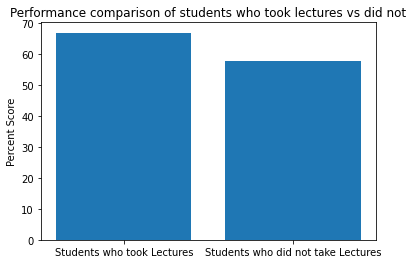

In [8]:
lecture_student_mean = squestions[squestions['user_id'].isin(slectures['user_id'].unique())]['answered_correctly'].mean() * 100
no_lecture_student_mean = squestions[~squestions['user_id'].isin(slectures['user_id'].unique())]['answered_correctly'].mean() * 100

plt.bar(['Students who took Lectures', 'Students who did not take Lectures'],[lecture_student_mean, no_lecture_student_mean])
plt.title('Performance comparison of students who took lectures vs did not')
plt.ylabel('Percent Score')
plt.show()

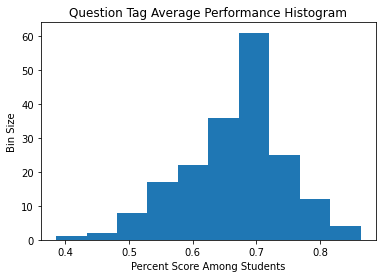

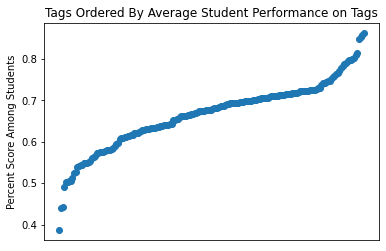

In [9]:
tags, tag_means = zip(*student_dataset.tag_means.items())


plt.hist(tag_means, bins=10)
plt.title('Question Tag Average Performance Histogram')
plt.xlabel('Percent Score Among Students')
plt.ylabel('Bin Size')
plt.show()

plt.scatter(np.arange(0,len(tag_means)), np.sort(tag_means))
plt.gca().xaxis.set_visible(False)
plt.title('Tags Ordered By Average Student Performance on Tags')
plt.ylabel('Percent Score Among Students')

del tag_means

Text(0.5, 1.0, 'Student Relative Timestamp Histogram')

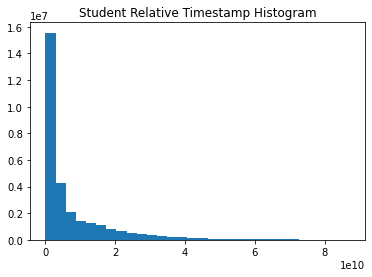

In [10]:
plt.hist(full['timestamp'], bins=30)
plt.title('Student Relative Timestamp Histogram')

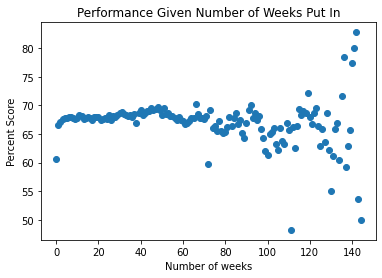

In [11]:
squestions['timestamp_int'] = squestions['timestamp'] // 1000 // 60 // 60 // 24 // 7
grp = squestions.groupby('timestamp_int')['answered_correctly'].mean() * 100
squestions = squestions.drop(columns='timestamp_int')
plt.scatter(grp.index, grp)
plt.title('Performance Given Number of Weeks Put In')
plt.xlabel('Number of weeks')
plt.ylabel('Percent Score')

del grp

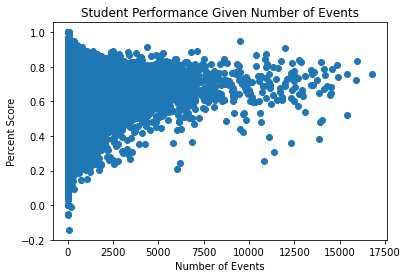

In [12]:
activity_grp = full.groupby(['user_id']).agg({'user_id': 'count', 'answered_correctly': 'mean'})
plt.scatter(activity_grp['user_id'], activity_grp['answered_correctly'])
plt.title('Student Performance Given Number of Events')
plt.xlabel('Number of Events')
plt.ylabel('Percent Score')
plt.show()

del activity_grp

In [13]:
# APPLICATION PHASE

def jagged_to_fixed_matrix(x, n , fill_value):
    a = np.full((len(x), n), fill_value)
    for i,xi in enumerate(x):
        end = min(n, len(xi))
        a[i][0:end] = [xi[j] for j in range(end)]
    return a

def create_batch_iter(n, skip):
    a = list(range(0, n, skip)) + [n]
    return [(a[i], a[i + 1]) for i in range(len(a) - 1)]

In [14]:
# APPLICATION PHASE

In [15]:
# Clear up some memory
del squestions
del slectures

In [16]:
# Data Preparation
full['prior_question_elapsed_time'] = full['prior_question_elapsed_time'].fillna(0)
full['prior_question_had_explanation'] = full['prior_question_had_explanation'].fillna(False)

# Transform timestamps into approx. month interval timestamps
full['timestamp'] = (full['timestamp'] // 1000 // 60 // 60 // 24 // 30).astype(np.uint16)

# Standardize relevant data
for col in ['timestamp', 'prior_question_elapsed_time']:
    u = full[col].mean()
    std = full[col].std()
    full[col] = ((full[col] - u) / std).fillna(u)

In [17]:
# We instead split on user_ids instead of rows, this makes more sense when the history of a user matters.
user_ids = full['user_id'].unique()
np.random.shuffle(user_ids)
valid_ids, train_ids = user_ids[0: int(len(user_ids) * 0.1)], user_ids[int(len(user_ids) * 0.1): len(user_ids)]
train = full[full['user_id'].isin(train_ids)]
valid = full[full['user_id'].isin(valid_ids)]

In [18]:
a, f, b = student_dataset.get_features(train[0:1].to_numpy())
extra_input_dim = len(f[0])
num_embeddings = student_dataset.num_tags + 1

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Network(student_dataset.num_tags + 1, extra_input_dim, 64, 32, embedding_dim=10).to(device)
loss_func = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

epoch_train_loss, epoch_train_accuracy = [], []
epoch_valid_loss, epoch_valid_accuracy, epoch_valid_fpr, epoch_valid_tpr = [], [], [], []

epoch = 0
for epoch_i in range(epoch + 10):
    epoch = epoch_i
    tq = tqdm(create_batch_iter(len(train), BATCH_SIZE))

    # Average Loss Variables
    total_loss = 0
    current_len = 0
    total_correct = 0
    total_len = 0
    student_dataset.reset()

    for i,j in tq:
        student_tags, f, labels = student_dataset.get_features(train[i:j].to_numpy())
        student_tags = torch.tensor(student_tags).long().to(device)
        n = len(f)

        f = torch.tensor(f).view(n, len(f[0])).float().to(device)

        labels = torch.tensor(labels.astype(np.bool)).view(n, 1).float().to(device)

        predictions = model(student_tags, f)

        loss = loss_func(predictions, labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_len += n
        total_loss += loss.item() * n

        pred = torch.sigmoid(predictions).cpu().view(n).detach().numpy()
        tgt = labels.cpu().view(n).detach().numpy()
        total_correct += sum(np.round(pred) == tgt)
        tq.set_description('EPOCH: ' + str(epoch) + ', Avg. Loss: ' + str(np.round(total_loss / current_len, 4)) + ', Train Acc:'  + \
                           str(np.round(total_correct / current_len * 100, 2)) + '%')

    epoch_train_loss.append(total_loss/ current_len)
    epoch_train_accuracy.append(total_correct / current_len * 100)

    tq = tqdm(create_batch_iter(len(valid), BATCH_SIZE))
    total_loss = 0
    current_len = 0
    total_correct = 0
    total_len = 0

    preds = []
    tgts = []
    with torch.no_grad():
        for i,j in tq:
            student_tags, f, labels = student_dataset.get_features(valid[i:j].to_numpy())
            student_tags = torch.tensor(student_tags).long().to(device)
            n = len(f)

            f = torch.tensor(f).view(n, len(f[0])).float().to(device)

            labels = torch.tensor(labels.astype(np.bool)).view(n, 1).float().to(device)

            predictions = model(student_tags, f)

            loss = loss_func(predictions, labels.float())


            current_len += n
            total_loss += loss.item() * n

            pred = torch.sigmoid(predictions).cpu().view(n).detach().flatten().numpy()
            tgt = labels.cpu().view(n).detach().flatten().numpy()
            preds.append(pred)
            tgts.append(tgt)
            total_correct += sum(np.round(pred) == np.array(tgt))
            tq.set_description('EPOCH: ' + str(epoch) + ', Avg. Loss: ' + str(np.round(total_loss / current_len, 4)) + ', Valid Acc: '  + \
                               str(np.round(total_correct / current_len * 100, 2)))

    epoch_valid_loss.append(total_loss/ current_len)
    epoch_valid_accuracy.append(total_correct / current_len * 100)
    preds = [p for b in preds for p in b]
    tgts = [p for b in tgts for p in b]
    fpr, tpr, _ = roc_curve(tgts, preds)
    epoch_valid_fpr.append(fpr)
    epoch_valid_tpr.append(tpr)
    print('Valid AUC: ', auc(fpr, tpr))

EPOCH: 9, Avg. Loss: 0.5818, Valid Acc: 70.13: 100%|██████████| 11195/11195 [02:19<00:00, 80.46it/s]


Valid AUC:  0.696282386554524
Valid AUC:  0.7102741889575841
Valid AUC:  0.7160331520539677
Valid AUC:  0.7159040580729367
Valid AUC:  0.7168277213618777
Valid AUC:  0.7209195940720128
Valid AUC:  0.7215458283609713
Valid AUC:  0.7174040877058797
Valid AUC:  0.7116567852617325
Valid AUC:  0.7141304023407752


In [20]:
torch.save({
    'model_state_dict': model.state_dict(),
    'epoch': epoch + 1,
    'epoch_train_loss': epoch_train_loss,
    'epoch_train_accuracy': epoch_train_accuracy,
    'epoch_valid_loss': epoch_valid_loss,
    'epoch_valid_accuracy': epoch_valid_accuracy,
    'epoch_valid_fpr': epoch_valid_fpr,
    'epoch_valid_tpr': epoch_valid_tpr
}, 'model.md')